In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.image_analysis import *
from core.utils.basic_functions import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re
import mat73
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
import matplotlib.image as mpimg
from PIL import Image
from scipy import stats, ndimage
from torchvision.utils import make_grid


In [2]:
# set some paths
data_root = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data"
save_root = os.path.join(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results', "select_160_proto_img_similarity")
os.makedirs(save_root, exist_ok=True)
proto_exp_path = os.path.join(data_root, "evolution", "unit_proto")
scram_exp_path = os.path.join(data_root, "scram", "unit_scram")
select_exp_path = os.path.join(data_root, "selectivity","select_160")


server_init = r"N:\PonceLab"

# List .mat files in each directory
recon_exp_files = list_mat_files(select_exp_path)
proto_exp_files = list_mat_files(proto_exp_path)
scram_exp_files = list_mat_files(scram_exp_path)

In [3]:
# let read one selectivity experiment data
exp_id = 2
select_data = mat73.loadmat(os.path.join(select_exp_path, recon_exp_files[exp_id]))
select_exp_date = recon_exp_files[exp_id].split('_')[0].split('-')[1]
# let open the data
# dict_keys(['all_images_name', 'all_trials_image', 'bk_resp', 'evoke_resp', 'img_pos', 'img_size', 'spikeID', 'spike_fn', 'stimuli_fn', 'unitID', 'wvfms'])
all_images_name = select_data['all_images_name']
all_images_name = np.array([x[0] for x in all_images_name])
all_trials_image = select_data['all_trials_image']
all_trials_image = np.array([x[0] for x in all_trials_image])
bk_resp = select_data['bk_resp']
evoke_resp = select_data['evoke_resp']
img_pos = select_data['img_pos']
img_size = select_data['img_size']
spikeID = select_data['spikeID']
spike_fn = select_data['spike_fn']
stimuli_fn = select_data['stimuli_fn']
unitID = select_data['unitID']
wvfms = select_data['wvfms']


In [4]:
# let get responses of units to each image and have then a np array of shape (n_images, n_units)
# let first z score the responses
evoke_resp_ZS = stats.zscore(evoke_resp, axis=1, nan_policy='omit')

seletivity_response_mean = np.zeros((len(all_images_name), len(unitID)))
seletivity_response_mean_real = np.zeros((len(all_images_name), len(unitID)))
selectivity_response_sem = np.zeros((len(all_images_name), len(unitID)))
for ii, img in enumerate(all_images_name):
    # let find the index of the image in the all_trials_image
    img_idx = np.where(np.array(all_trials_image) == img)[0]
    # let get the responses of the units to this image
    img_resp = evoke_resp_ZS[:, img_idx]
    # let get the mean and sem of the responses
    seletivity_response_mean[ii, :] = np.nanmean(img_resp, axis=1)
    seletivity_response_mean_real[ii, :] = np.nanmean(evoke_resp[:, img_idx], axis=1)
    selectivity_response_sem[ii, :] = np.nanstd(img_resp, axis=1) / np.sqrt(np.shape(img_resp)[1])
    

C:\Users\Alireza\AppData\Local\Temp\ipykernel_7164\99669636.py:14: RuntimeWarning: Mean of empty slice
  seletivity_response_mean[ii, :] = np.nanmean(img_resp, axis=1)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [39]:
# let load the proto and corosponding mask if it posible plus the size 
# let save the proto and mask and other info in a pd
proto_and_mask_info = pd.DataFrame(columns=['exp_name', 'exp_id', 'proto_img',
                                            'proto_mask_exp', 'proto_mask_lin', 'proto_mask_lin_smoothed',
                                            'proto_size', 'proto_pos', 'chan_id', 'unit_id',
                                            'protoRespMean', 'init_img', 'exp_date'])
c = 0
iamge_size = 256
non_significant_exp = []
for proto_exp_i in range(len(proto_exp_files)):
    # use the extract_info function to extract the information from the filename
    #proto_file = [f for f in proto_exp_files if f.count(f"expId{proto_exp_id+1:03d}")][0]
    proto_file = proto_exp_files[proto_exp_i]
    proto_exp_data = mat73.loadmat(os.path.join(proto_exp_path, proto_file))
    proto_exp_info = extract_info_proto_exp(proto_file)
    exp_name_common = '-'.join(proto_exp_info['exp_name'].split('-')[0:2])
    chan_id = proto_exp_info['chan']
    unit_id = proto_exp_info['unit']
    proto_exp_id = proto_exp_info['expId']


    # the scram exp data file name is formated like this [exp_name]_exp_idXXX_chanXX_unitX.mat for example like Caos-30112023-008_expId022_chan71_unit2
    # let's load the coresponded scram exp data which should be [exp_name_common]-*_chan[chan_id]_unit[unit_id].mat
    scram_exp_file = [f for f in scram_exp_files if (f.count(f"chan{chan_id:02d}") and f.count(f"unit{unit_id}") and f.count(exp_name_common))]
    # continue if the file is not found
    if len(scram_exp_file) == 0:
        continue
    if (proto_exp_data['p_evol'] > .01):
        non_significant_exp.append(proto_exp_id)
        continue
    scram_exp_file = scram_exp_file[0]
    scram_exp_info = mat73.loadmat(os.path.join(scram_exp_path, scram_exp_file))
    proto_size = scram_exp_info['img_size']
    proto_pos = scram_exp_info['img_pos']
    protoRespMean = scram_exp_info['protoRespMean']
    exp_date = scram_exp_file.split('_')[0].split('-')[1]

    #proto_img = proto_exp_data['top_mean_img_selected']
    proto_img = scram_exp_info['final_gen_img']
    init_img = proto_exp_data['init_img']
    proto_mask_exp = scram_exp_info['overlapped_mask_exp']
    proto_mask_lin = scram_exp_info['overlapped_mask_lin']
    proto_mask_lin_smoothed = ndimage.gaussian_filter(proto_mask_lin, 25)
    # if mask is not the size of image_size then resize it
    if proto_mask_exp.shape[0] != iamge_size:
        proto_mask_exp = cv2.resize(proto_mask_exp, (iamge_size, iamge_size))
    if proto_mask_lin.shape[0] != iamge_size:
        proto_mask_lin = cv2.resize(proto_mask_lin, (iamge_size, iamge_size))
    if proto_mask_lin_smoothed.shape[0] != iamge_size:
        proto_mask_lin_smoothed = cv2.resize(proto_mask_lin_smoothed, (iamge_size, iamge_size))
    # if the proto_img is not the size of image_size then resize it
    if proto_img.shape[0] != iamge_size:
        proto_img = cv2.resize(proto_img, (iamge_size, iamge_size))
    # iloc with c
    proto_and_mask_info.loc[c] = [exp_name_common, proto_exp_id, proto_img, proto_mask_exp, proto_mask_lin, proto_mask_lin_smoothed,
                                   proto_size, proto_pos, chan_id, unit_id, protoRespMean, init_img, exp_date]
    c += 1
proto_and_mask_info['proto_img_torch'] = proto_and_mask_info['proto_img'].apply(uint8_image_to_pytorch)
proto_and_mask_info['init_img_torch'] = proto_and_mask_info['init_img'].apply(uint8_image_to_pytorch)
print(f"Number of expected proto images: {len(scram_exp_files)- len(non_significant_exp)}")
print(f"Number of proto images loaded: {len(proto_and_mask_info)}")

Number of expected proto images: 67
Number of proto images loaded: 67


NameError: name 'non_significant_exp' is not defined

In [9]:
# let load all  image as the thorch and save them in a pd from the stimuli_fn
select_160_images = pd.DataFrame(columns=['img_name', 'img_torch'])
for img_i in range(len(all_images_name)):
    img_name = all_images_name[img_i]
    img_path_folder = os.path.join(server_init, prune_path(stimuli_fn))
    # get all files in the folder that is similar to the image name
    full_img_name = [f for f in os.listdir(img_path_folder) if f.count(img_name)][0]
    img = Image.open(os.path.join(img_path_folder, full_img_name)).convert('RGB')
    select_160_images.loc[img_i] = [img_name, ToTensor()(img)]
# let have the image in a torch format with the same orther of all_images_name
select_160_images_tensor = list()
for img_name in all_images_name:
    select_160_images_tensor.append(select_160_images[select_160_images['img_name'] == img_name]['img_torch'].values[0])
select_160_images_tensor = torch.stack(select_160_images_tensor)

Text(0.5, 1.0, 'ILSVRC2012_val_00004827')

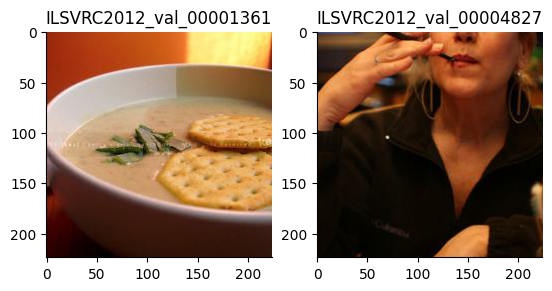

In [10]:
# let see if it makes sense by printin the masked image amd masked centered image :))
fig, ax = plt.subplots(1, 2)
ppi = 34
ax[0].imshow(ToPILImage()(select_160_images_tensor[4]))
ax[0].set_title(all_images_name[4])
ax[1].imshow(ToPILImage()(select_160_images_tensor[12]))
ax[1].set_title(all_images_name[12])

In [11]:
img_size = select_data['img_size']
pixels_per_deg = 128
# let's get the real pos for the proto image and the mask based on the img_poss and img_size and save them all in a list
# we have all proto_img_torch and proto_mask_tensor so let do it    
real_pos_proto_img_list = [get_real_pos_img_torch(proto_and_mask_info['proto_img_torch'].iloc[i], proto_and_mask_info['proto_pos'].iloc[i], 
                                            proto_and_mask_info['proto_size'].iloc[i], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(proto_and_mask_info))]
real_pos_init_img_list = [get_real_pos_img_torch(proto_and_mask_info['init_img_torch'].iloc[i], proto_and_mask_info['proto_pos'].iloc[i],
                                            proto_and_mask_info['proto_size'].iloc[i], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(proto_and_mask_info))]
real_pos_mask_list = [get_real_pos_img_torch(torch.from_numpy(proto_and_mask_info['proto_mask_lin_smoothed'].iloc[i]), proto_and_mask_info['proto_pos'].iloc[i],
                                    proto_and_mask_info['proto_size'].iloc[i], screen_size=img_size, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(proto_and_mask_info))]

real_pos_bin_mask_list = [make_binary_mask_torch(mask, x_std=1.25) for mask in real_pos_mask_list]

proto_chan_id = [proto_and_mask_info['chan_id'].iloc[i] for i in range(len(proto_and_mask_info))]
proto_unit_id = [proto_and_mask_info['unit_id'].iloc[i] for i in range(len(proto_and_mask_info))]
proto_resp_mean = [proto_and_mask_info['protoRespMean'].iloc[i] for i in range(len(proto_and_mask_info))]
proto_exp_date = [proto_and_mask_info['exp_date'].iloc[i] for i in range(len(proto_and_mask_info))]
# let's convert the list to tensor
real_pos_proto_img_tensor = torch.stack(real_pos_proto_img_list)
real_pos_init_img_tensor = torch.stack(real_pos_init_img_list)
real_pos_mask_tensor = torch.stack(real_pos_mask_list)
real_pos_bin_mask_tensor = torch.stack(real_pos_bin_mask_list)
real_pos_proto_img_tensor_masked = apply_mask_to_image_torch(real_pos_proto_img_tensor, real_pos_bin_mask_tensor)
real_pos_init_img_tensor_masked = apply_mask_to_image_torch(real_pos_init_img_tensor, real_pos_bin_mask_tensor)
# let centered the image on the mask center, we can use get_real_pos_img_torch function with 2 degree screen size
# let's get the mask center
mask_center_list = [find_mask_center(mask) for mask in real_pos_bin_mask_tensor]
mask_center_deg = np.array([x[2] for x in mask_center_list])
real_pos_proto_img_tensor_masked_centered = torch.stack([get_real_pos_img_torch(real_pos_proto_img_tensor_masked[i], -mask_center_deg[i], img_size,
                                                                    screen_size=2, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(real_pos_proto_img_tensor_masked))])
                                                        #TO DO: THE SCREEN SIZE IS A 
real_pos_init_img_tensor_masked_centered = torch.stack([get_real_pos_img_torch(real_pos_init_img_tensor_masked[i], -mask_center_deg[i], img_size,
                                                                    screen_size=2, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(real_pos_init_img_tensor_masked))])

img_size_pixels = int(img_size * pixels_per_deg)
select_160_images_tensor = F.resize(select_160_images_tensor, [img_size_pixels, img_size_pixels])

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(-0.5, 2581.5, 1807.5, -0.5)

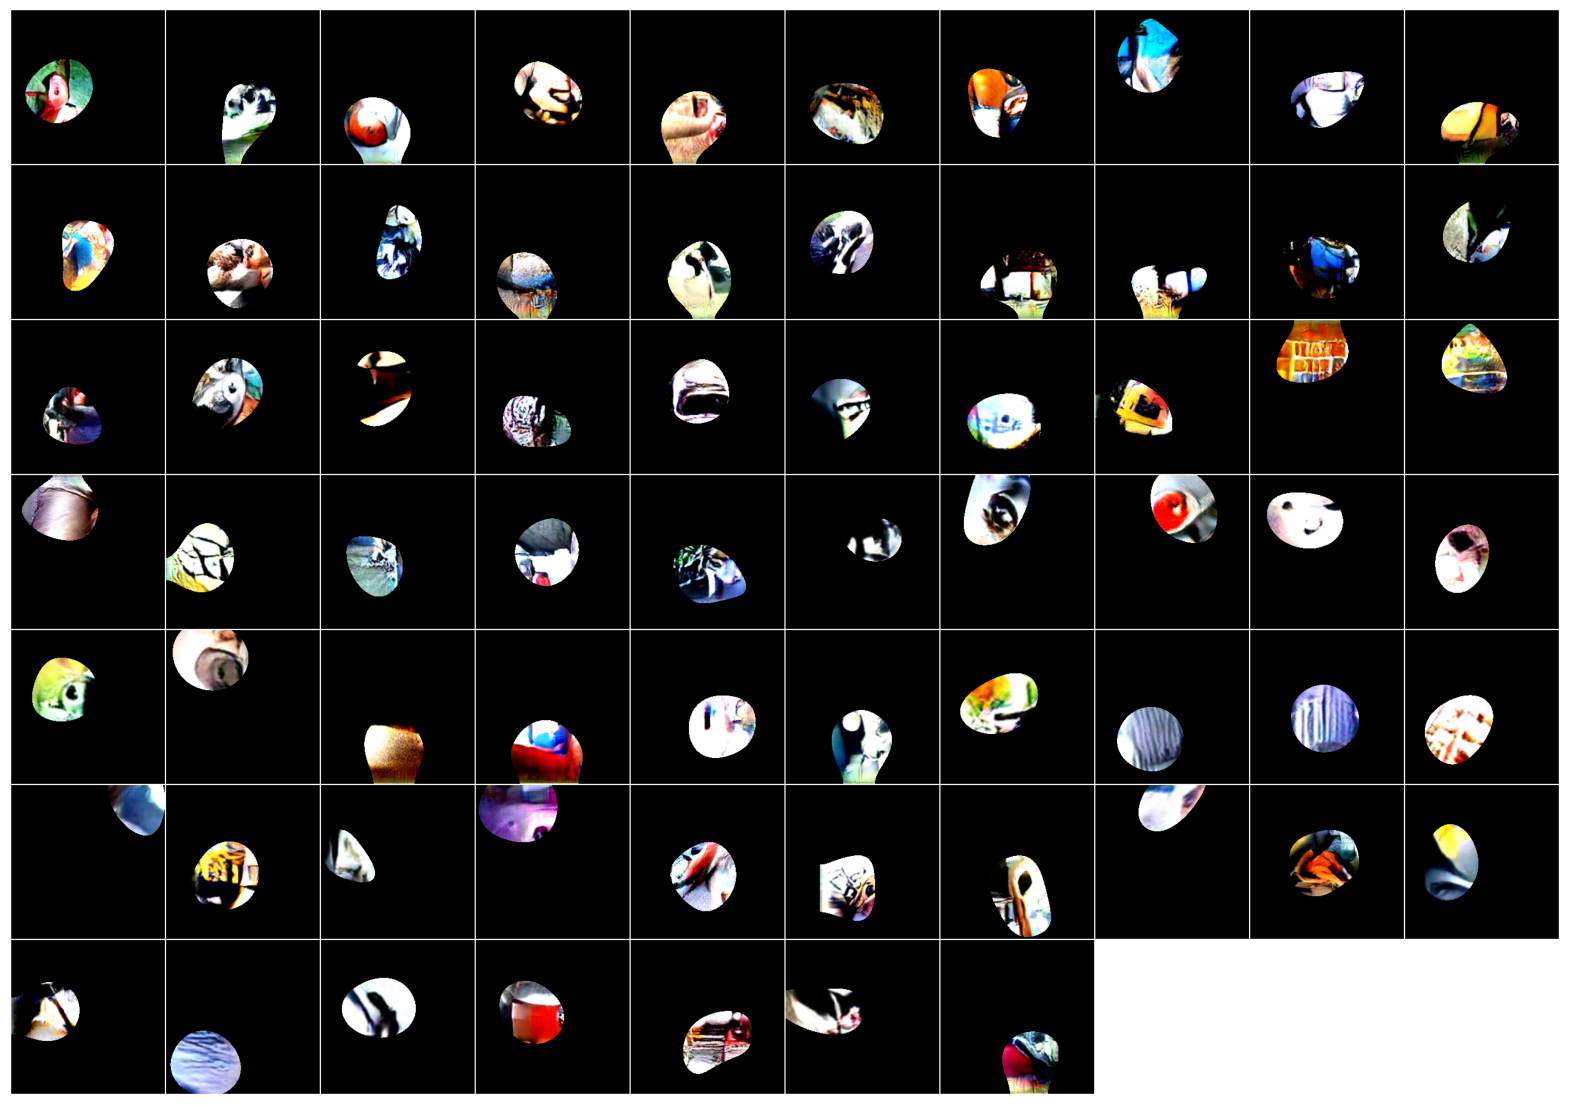

In [12]:
# let make a grid of the real_pos_proto_img_tensor_masked
real_pos_proto_img_tensor_masked_grid = make_grid(real_pos_proto_img_tensor_masked, nrow=10, padding=2, pad_value=1)
# let print  the grid
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(ToPILImage()(real_pos_proto_img_tensor_masked_grid))
plt.axis('off')

Text(0.5, 1.0, 'IT Prototypes')

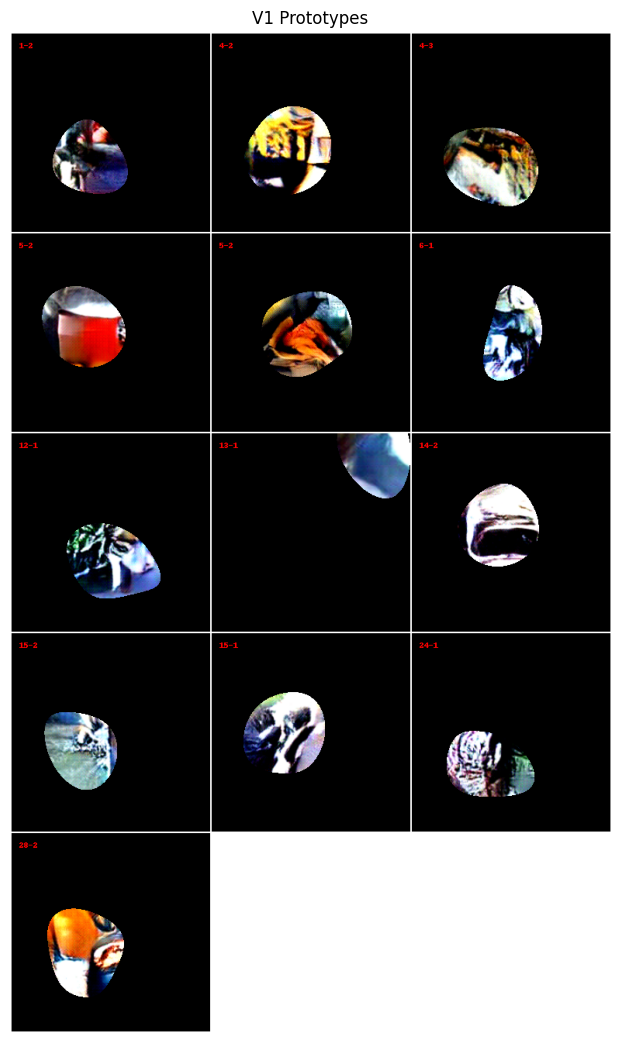

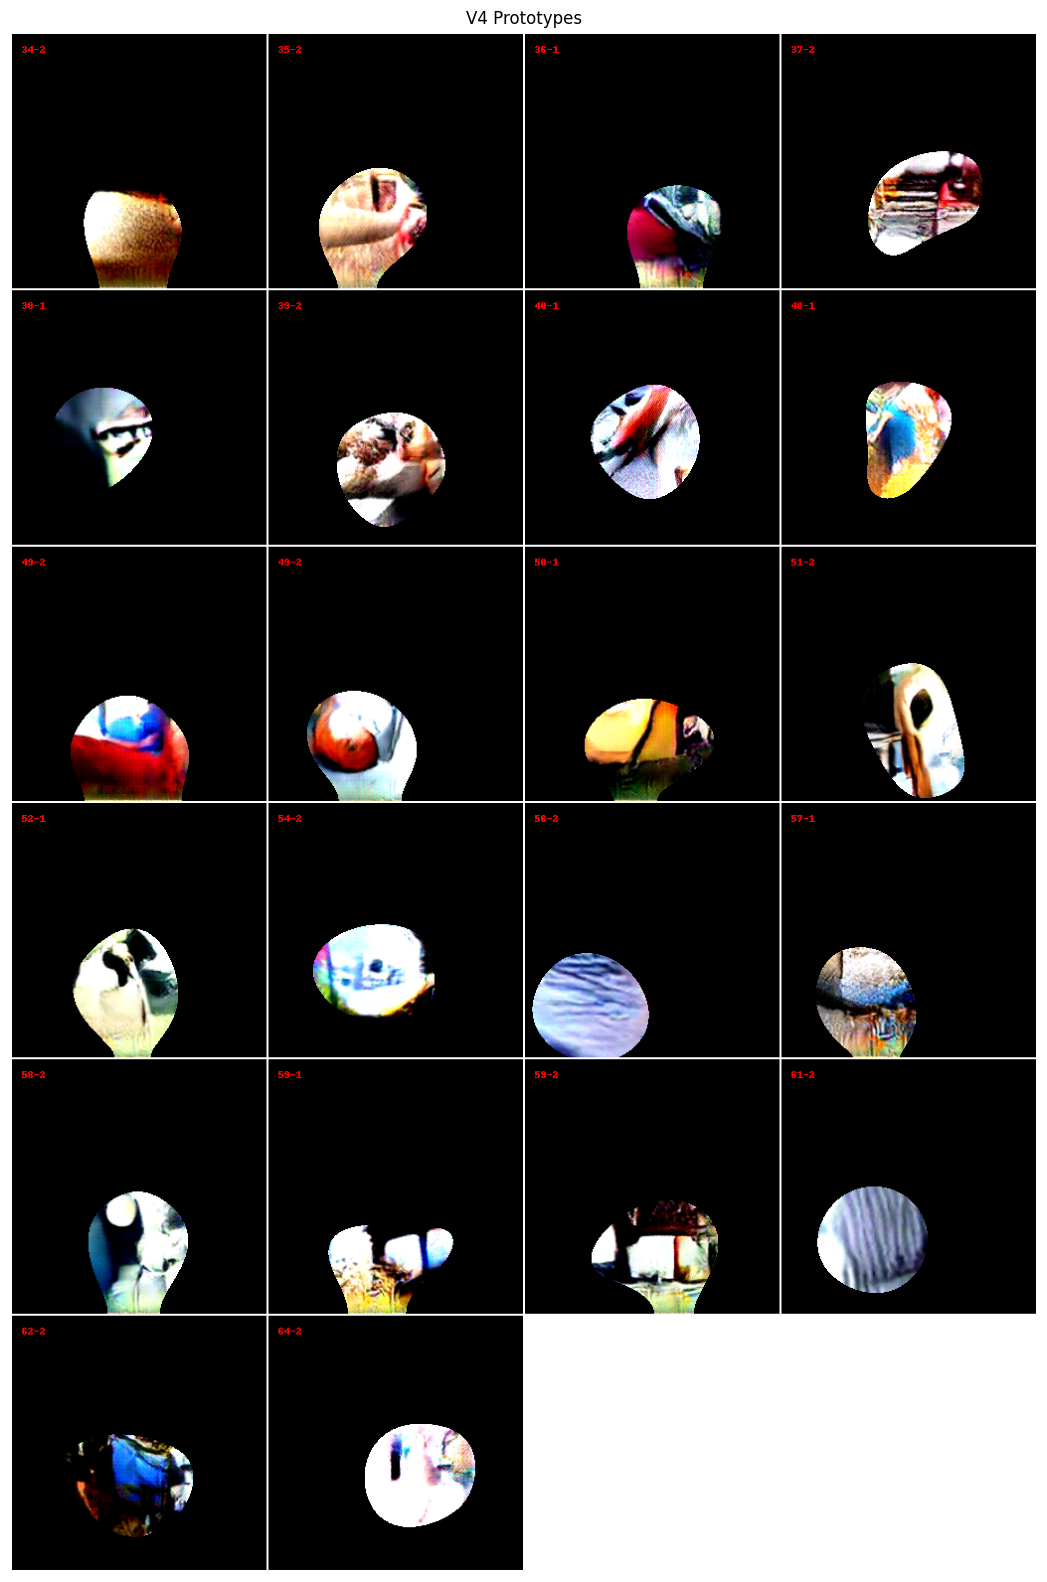

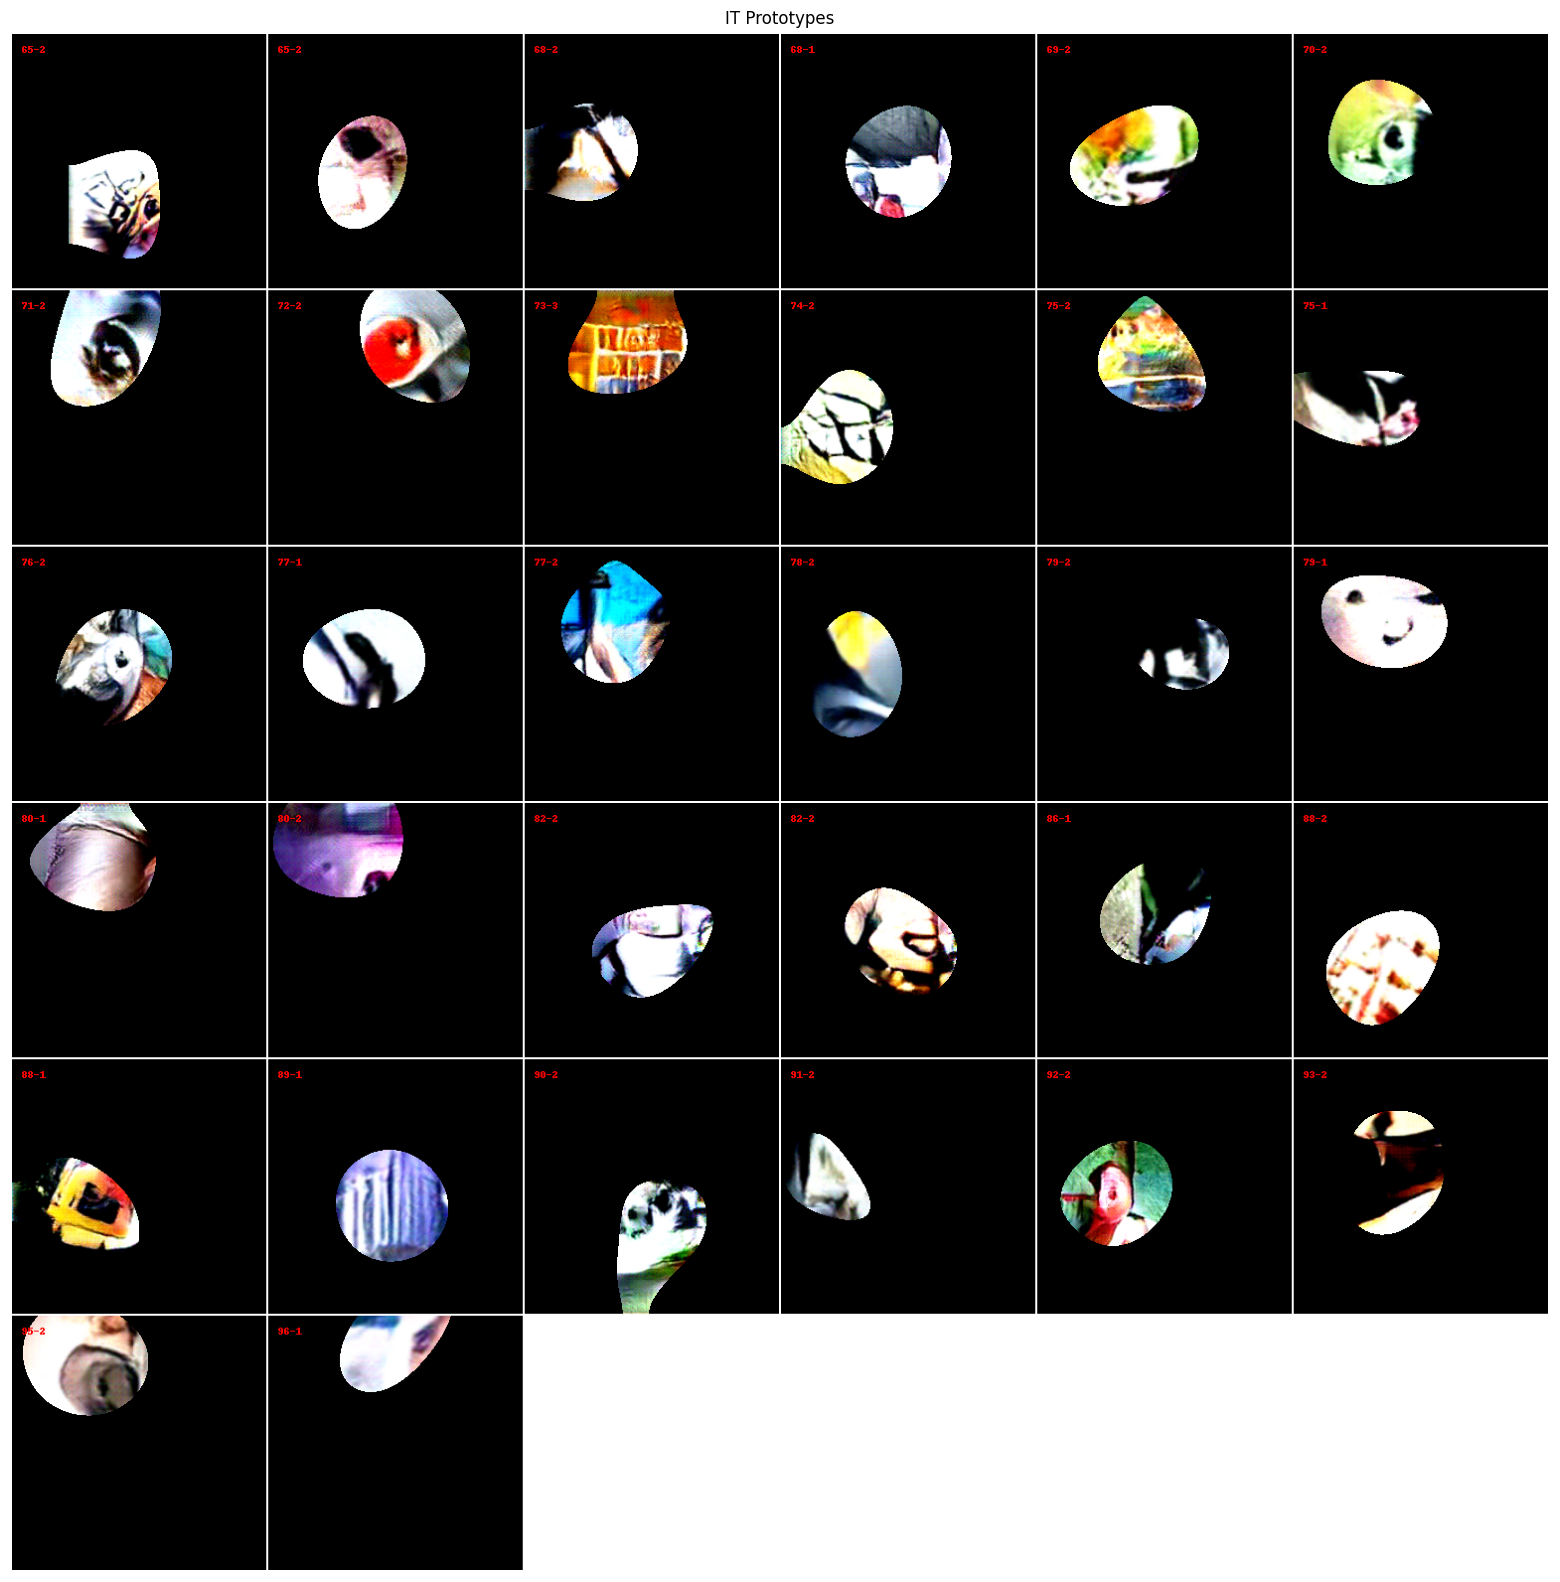

In [14]:
# the channels are thes 
# 1:32 is V1
# 33:64 is V4
# 65:96 is IT

# let get a grid for prototypes of the units each area
real_pos_proto_img_tensor_masked_with_text = add_text_to_image(real_pos_proto_img_tensor_masked, [f"{chan_i:.0f}-{unit_i:.0f}" for chan_i, unit_i in zip(proto_chan_id, proto_unit_id)], (10, 10))
arg_sort = np.argsort(proto_chan_id)
real_pos_proto_img_tensor_masked_with_text_sorted = real_pos_proto_img_tensor_masked_with_text[arg_sort]
proto_chan_id_sorted = np.array(proto_chan_id)[arg_sort]
vi_proto = real_pos_proto_img_tensor_masked_with_text_sorted[np.array(proto_chan_id_sorted) < 33]
v2_proto = real_pos_proto_img_tensor_masked_with_text_sorted[(np.array(proto_chan_id_sorted) > 32) & (np.array(proto_chan_id_sorted) < 65)]
it_proto = real_pos_proto_img_tensor_masked_with_text_sorted[np.array(proto_chan_id_sorted) > 64]

v1_proto_grid = make_grid(vi_proto, nrow=3, padding=2, pad_value=1)
v2_proto_grid = make_grid(v2_proto, nrow=4, padding=2, pad_value=1)
it_proto_grid = make_grid(it_proto, nrow=6, padding=2, pad_value=1)

fig, ax = plt.subplots(1, 1, figsize=(13, 13))
plt.imshow(ToPILImage()(v1_proto_grid))
plt.axis('off')
plt.title('V1 Prototypes')

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(ToPILImage()(v2_proto_grid))
plt.axis('off')
plt.title('V4 Prototypes')

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
plt.imshow(ToPILImage()(it_proto_grid))
plt.axis('off')
plt.title('IT Prototypes')

KeyboardInterrupt: 

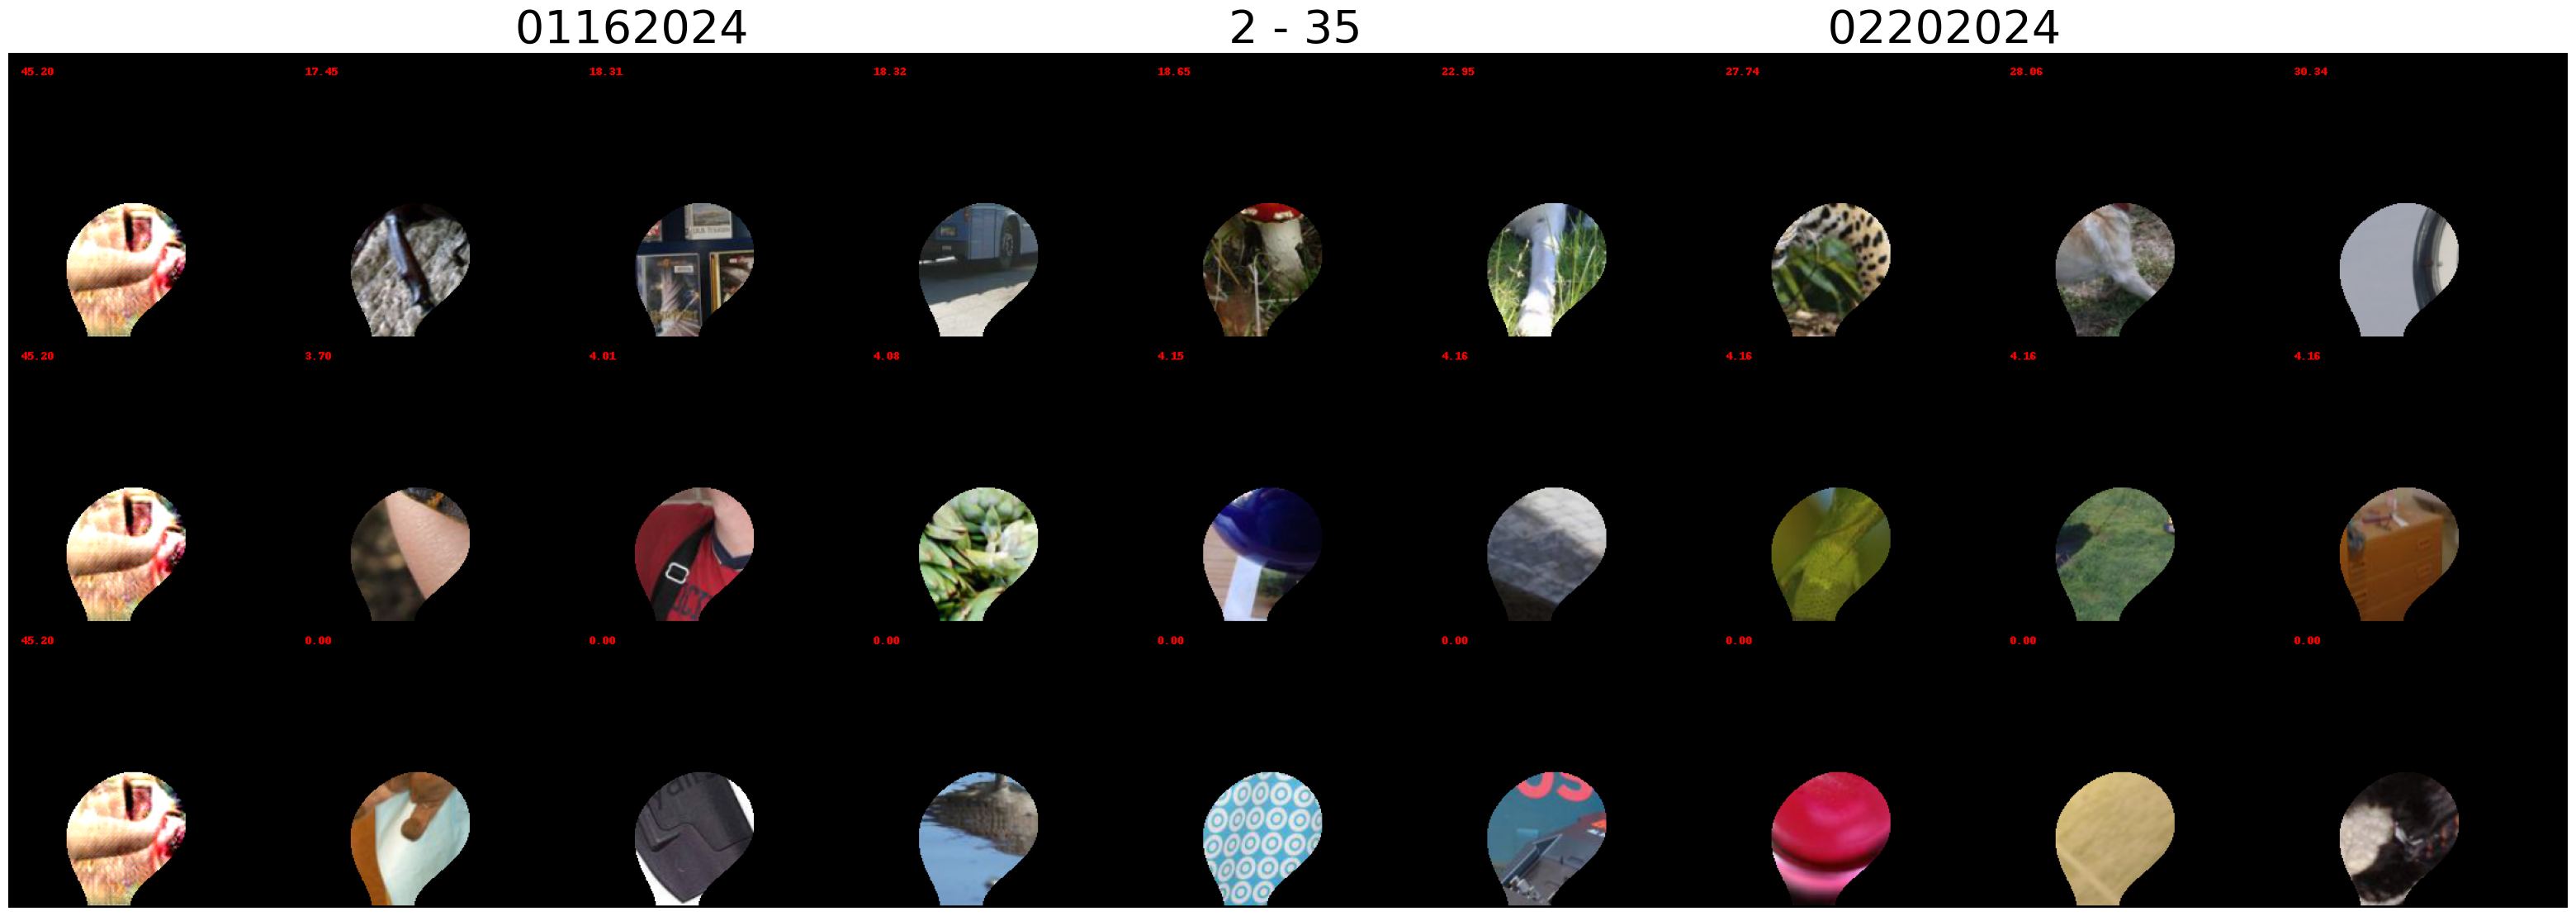

In [15]:
# for some cell let get 5 mose selective images, 5 middle selective images and 5 least selective images
# but let masked all of them with the coresponded proto mask
save_path = os.path.join(save_root, "unit_image_prefrences_exp_masked")
os.makedirs(save_path, exist_ok=True)

for pi in range(len(proto_chan_id)):
    ui = proto_unit_id[pi]
    chi = proto_chan_id[pi]
    cell_id = np.where((np.array(unitID) == ui) & (np.array(spikeID) == chi))[0]
    if len(cell_id) == 1:
        
        unit_resp = seletivity_response_mean_real[:, cell_id].squeeze()
        # ler resort the select_160_images_tensor based on the unit_resp (descending)
        sort_idx = np.argsort(unit_resp, axis=0)
        unit_resp_sort = unit_resp[sort_idx]
        select_160_images_tensor_sorted = select_160_images_tensor[sort_idx]
        # let aplay the msak to the images
        select_160_images_tensor_sorted_masked = apply_mask_to_image_torch(select_160_images_tensor_sorted, real_pos_bin_mask_tensor[pi].repeat(len(select_160_images_tensor_sorted), 1, 1))
        # let know print the 5 mmost selective images, 5 middle selective images and 5 least selective images in 5 rows and at the start of each row print the proto mask image
        # let first get the mask image
        mask_proto_img = real_pos_proto_img_tensor_masked[pi]
        # let put them in a tensor tham make a grid of them
        # add activity as a text in the image
        mask_proto_img = add_text_to_image(mask_proto_img, f"{proto_resp_mean[pi]:.2f}", (10, 10))

        all_images = torch.cat([mask_proto_img.unsqueeze(0),\
                                add_text_to_image(select_160_images_tensor_sorted_masked[-8:], [f"{t:.2f}" for t in unit_resp_sort[-8:]], (10, 10)),\
                        mask_proto_img.unsqueeze(0), add_text_to_image(select_160_images_tensor_sorted_masked[80:88], [f"{t:.2f}" for t in unit_resp_sort[80:88]], (10, 10)),\
                        mask_proto_img.unsqueeze(0), add_text_to_image(select_160_images_tensor_sorted_masked[:8], [f"{t:.2f}" for t in unit_resp_sort[:8]], (10, 10))])
        # let make a grid of them
        grid = make_grid(all_images, nrow=9)
        plt.figure(figsize=(40, 40))
        plt.imshow(ToPILImage()(grid))
        plt.axis('off')
        # in title we want this in order: proto exp date - unit id - channel id - selectivity exp date
        plt.title(f"{proto_exp_date[pi]}                                 {ui} - {chi}                                {select_exp_date}", fontsize=40)
        # let save the ima
        plt.savefig(os.path.join(save_path, f"unit_{ui}_channel_{chi}_{pi}.png"), bbox_inches='tight')
        plt.close()


Text(0.5, 1.0, 'p centered ')

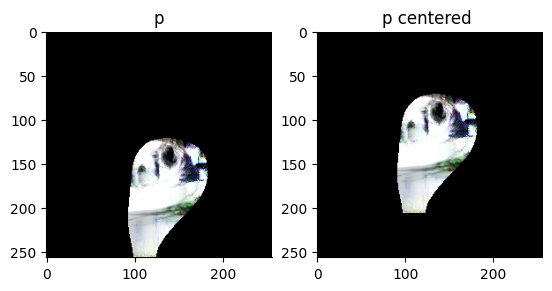

In [ ]:
# let see if it makes sense by printin the masked image amd masked centered image :))
fig, ax = plt.subplots(1, 2)
ppi = 1
ax[0].imshow(ToPILImage()(real_pos_proto_img_tensor_masked[ppi]))
ax[0].set_title('p')
ax[1].imshow(ToPILImage()(real_pos_proto_img_tensor_masked_centered[ppi]))
ax[1].set_title('p centered ')


In [16]:
selected_channel = [12, 38, 68, 80, 88, 14, 15, 59, 75, 76]
selected_unit = [1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
proto_filter_idx = np.array([np.where((np.array(proto_chan_id) == selected_channel[i]) & (np.array(proto_unit_id) == selected_unit[i]))[0][0] for i in range(len(selected_channel))])
cell_filter_idx = np.array([np.where((np.array(unitID) == selected_unit[i]) & (np.array(spikeID) == selected_channel[i]))[0][0] for i in range(len(selected_channel))])
real_pos_bin_mask_tensor_selected = real_pos_bin_mask_tensor[proto_filter_idx]
real_pos_proto_img_tensor_masked_seleted = real_pos_proto_img_tensor_masked[proto_filter_idx]
real_pos_init_img_tensor_masked_seleted = real_pos_init_img_tensor_masked[proto_filter_idx]
real_pos_proto_img_tensor_masked_centered_seleted = real_pos_proto_img_tensor_masked_centered[proto_filter_idx]
real_pos_init_img_tensor_masked_centered_seleted = real_pos_init_img_tensor_masked_centered[proto_filter_idx]
mask_center_deg_selected = mask_center_deg[proto_filter_idx]



In [29]:
# let's get target and proto similarity and the response of the units corresponding to the proto and target
# dont show the warnings
import warnings
warnings.filterwarnings("ignore")

from core.utils.image_similarity import TorchImageDistance
img_dist_obj = TorchImageDistance()
#img_dist_obj.set_first_image_batch(real_pos_proto_img_tensor_masked)
img_dist_obj.set_first_image_batch(real_pos_proto_img_tensor_masked_centered_seleted)

img_dist_obj.set_second_image_batch(real_pos_init_img_tensor_masked_centered_seleted)
l2_dist_init, _ = img_dist_obj.get_L2_distance()
mse_dist_init,_ = img_dist_obj.get_MSE_distance()
lpips_dist_init = img_dist_obj.get_LPIPS_distance()
CNN_cosine_dist_init,CNN_cosine_dist_mat_init = img_dist_obj.get_CCN_distance(units_slice='center')
CNN_cosine_dist_ly_init = np.mean(CNN_cosine_dist_mat_init, axis=(0))


unit_resp_dist_pd = pd.DataFrame(columns=['img_name', 'unit_id', 'chan_id', 'l2_dist', 'mse_dist', 'lpips_dist', 'CNN_cosine_dist',\
                                          'CNN_cosine_dist_l1', 'CNN_cosine_dist_l2', 'CNN_cosine_dist_l3', 'CNN_cosine_dist_l4',
                                            'l2_dist_sim_index', 'mse_dist_sim_index', 'lpips_dist_sim_index', 'CNN_cosine_dist_sim_index',\
                                            'CNN_cosine_dist_sim_l1', 'CNN_cosine_dist_sim_l2', 'CNN_cosine_dist_sim_l3', 'CNN_cosine_dist_sim_l4', 'unit_resp'])

for ii in range(len(all_images_name)):
    img_name = all_images_name[ii]
    # let have the image form the select_160_images_pd
    target_img = select_160_images[select_160_images['img_name'] == img_name]['img_torch'].iloc[0]
    img_size_pixels = int(img_size * pixels_per_deg)
    target_img = F.resize(target_img, [img_size_pixels, img_size_pixels])
    # let make a tensor of the reapeated targer image that is the same size as the real_pos_proto_img_tensor

    #target_img_repeated = target_img.repeat(real_pos_proto_img_tensor.shape[0], 1, 1, 1)
    target_img_repeated = target_img.repeat(len(proto_filter_idx), 1, 1, 1)

    #target_img_repeated_masked = apply_mask_to_image_torch(target_img_repeated, real_pos_bin_mask_tensor)
    target_img_repeated_masked = apply_mask_to_image_torch(target_img_repeated, real_pos_bin_mask_tensor_selected)

    #target_img_repeated_masked_centered = torch.stack([get_real_pos_img_torch(target_img_repeated_masked[i], -mask_center_deg[i], img_size,
    #                                                                screen_size=2, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(target_img_repeated_masked))])
    target_img_repeated_masked_centered = torch.stack([get_real_pos_img_torch(target_img_repeated_masked[i], -mask_center_deg_selected[i], img_size,
                                                                    screen_size=2, grayness_level=0, pixels_per_deg=pixels_per_deg) for i in range(len(target_img_repeated_masked))])
    
    img_dist_obj.set_second_image_batch(target_img_repeated_masked_centered)
    l2_dist, _ = img_dist_obj.get_L2_distance()
    mse_dist,_ = img_dist_obj.get_MSE_distance()
    lpips_dist = img_dist_obj.get_LPIPS_distance()
    CNN_cosine_dist,CNN_cosine_dist_mat = img_dist_obj.get_CCN_distance(units_slice='center')
    CNN_cosine_dist_ly = np.mean(CNN_cosine_dist_mat, axis=(0))

    l2_dist_sim_index = (l2_dist_init - l2_dist) / l2_dist_init
    mse_dist_sim_index = (mse_dist_init - mse_dist) / mse_dist_init
    lpips_dist_sim_index = (lpips_dist_init - lpips_dist) / lpips_dist_init
    CNN_cosine_dist_sim_index = (CNN_cosine_dist_init - CNN_cosine_dist) / CNN_cosine_dist_init
    CNN_cosine_dist_sim_l1 = (CNN_cosine_dist_ly_init[0] - CNN_cosine_dist_ly[0]) / CNN_cosine_dist_ly_init[0]
    CNN_cosine_dist_sim_l2 = (CNN_cosine_dist_ly_init[1] - CNN_cosine_dist_ly[1]) / CNN_cosine_dist_ly_init[1]
    CNN_cosine_dist_sim_l3 = (CNN_cosine_dist_ly_init[2] - CNN_cosine_dist_ly[2]) / CNN_cosine_dist_ly_init[2]
    CNN_cosine_dist_sim_l4 = (CNN_cosine_dist_ly_init[3] - CNN_cosine_dist_ly[3]) / CNN_cosine_dist_ly_init[3]


    unit_resp = seletivity_response_mean[ii, cell_filter_idx]
    sun_resp_dist = pd.DataFrame({'img_name': img_name, 'unit_id': selected_unit, 'chan_id': selected_channel, 'l2_dist': l2_dist, 'mse_dist': mse_dist, 'lpips_dist': lpips_dist, 'CNN_cosine_dist': CNN_cosine_dist, \
                                    'CNN_cosine_dist_l1': CNN_cosine_dist_ly[0], 'CNN_cosine_dist_l2': CNN_cosine_dist_ly[1], 'CNN_cosine_dist_l3': CNN_cosine_dist_ly[2], 'CNN_cosine_dist_l4': CNN_cosine_dist_ly[3], \
                                    'l2_dist_sim_index': l2_dist_sim_index, 'mse_dist_sim_index': mse_dist_sim_index, 'lpips_dist_sim_index': lpips_dist_sim_index, 'CNN_cosine_dist_sim_index': CNN_cosine_dist_sim_index, \
                                    'CNN_cosine_dist_sim_l1': CNN_cosine_dist_sim_l1, 'CNN_cosine_dist_sim_l2': CNN_cosine_dist_sim_l2, 'CNN_cosine_dist_sim_l3': CNN_cosine_dist_sim_l3, 'CNN_cosine_dist_sim_l4': CNN_cosine_dist_sim_l4, 'unit_resp': unit_resp})
    
    unit_resp_dist_pd = pd.concat([unit_resp_dist_pd, sun_resp_dist])

img_dist_obj.memory_cleanup()    


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
use the default resnet50 weights
Layer .layer1.2.BatchNorm2dbn3 center units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 center units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 center units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 center units from feature tensor of shape (2048, 8, 8)
Layer .layer1.2.BatchNorm2dbn3 center units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 center units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 center units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 center units from feature tensor of shape (2048, 8, 8)
Layer .V1.BatchNorm2dnorm2 center units from feature tensor of shape (64, 57, 57)
Lay

In [25]:
# let's get target and proto similarity and the response of the units corresponding to the proto and target
# dont show the warnings
'''import warnings
warnings.filterwarnings("ignore")

from core.utils.image_similarity import TorchImageDistance
img_dist_obj = TorchImageDistance()
#img_dist_obj.set_first_image_batch(real_pos_proto_img_tensor_masked)

real_pos_proto_img_tensor_seleted = real_pos_proto_img_tensor[proto_filter_idx]
real_pos_init_img_tensor_seleted = real_pos_init_img_tensor[proto_filter_idx]


img_dist_obj.set_first_image_batch(real_pos_proto_img_tensor_seleted)
img_dist_obj.set_second_image_batch(real_pos_init_img_tensor_seleted)

l2_dist_init, _ = img_dist_obj.get_L2_distance()
mse_dist_init,_ = img_dist_obj.get_MSE_distance()
lpips_dist_init = img_dist_obj.get_LPIPS_distance()
CNN_cosine_dist_init,CNN_cosine_dist_mat_init = img_dist_obj.get_CCN_distance(units_slice='all')
CNN_cosine_dist_ly_init = np.mean(CNN_cosine_dist_mat_init, axis=(0))


unit_resp_dist_pd = pd.DataFrame(columns=['img_name', 'unit_id', 'chan_id', 'l2_dist', 'mse_dist', 'lpips_dist', 'CNN_cosine_dist',\
                                          'CNN_cosine_dist_l1', 'CNN_cosine_dist_l2', 'CNN_cosine_dist_l3', 'CNN_cosine_dist_l4',
                                            'l2_dist_sim_index', 'mse_dist_sim_index', 'lpips_dist_sim_index', 'CNN_cosine_dist_sim_index',\
                                            'CNN_cosine_dist_sim_l1', 'CNN_cosine_dist_sim_l2', 'CNN_cosine_dist_sim_l3', 'CNN_cosine_dist_sim_l4', 'unit_resp'])

for ii in range(len(all_images_name)):
    img_name = all_images_name[ii]
    # let have the image form the select_160_images_pd
    target_img = select_160_images[select_160_images['img_name'] == img_name]['img_torch'].iloc[0]
    img_size_pixels = int(img_size * pixels_per_deg)
    target_img = F.resize(target_img, [img_size_pixels, img_size_pixels])
    # let make a tensor of the reapeated targer image that is the same size as the real_pos_proto_img_tensor

    #target_img_repeated = target_img.repeat(real_pos_proto_img_tensor.shape[0], 1, 1, 1)
    target_img_repeated = target_img.repeat(len(proto_filter_idx), 1, 1, 1)
    
    img_dist_obj.set_second_image_batch(target_img_repeated)
    l2_dist, _ = img_dist_obj.get_L2_distance()
    mse_dist,_ = img_dist_obj.get_MSE_distance()
    lpips_dist = img_dist_obj.get_LPIPS_distance()
    CNN_cosine_dist,CNN_cosine_dist_mat = img_dist_obj.get_CCN_distance(units_slice='all')
    CNN_cosine_dist_ly = np.mean(CNN_cosine_dist_mat, axis=(0))

    l2_dist_sim_index = (l2_dist_init - l2_dist) / l2_dist_init
    mse_dist_sim_index = (mse_dist_init - mse_dist) / mse_dist_init
    lpips_dist_sim_index = (lpips_dist_init - lpips_dist) / lpips_dist_init
    CNN_cosine_dist_sim_index = (CNN_cosine_dist_init - CNN_cosine_dist) / CNN_cosine_dist_init
    CNN_cosine_dist_sim_l1 = (CNN_cosine_dist_ly_init[0] - CNN_cosine_dist_ly[0]) / CNN_cosine_dist_ly_init[0]
    CNN_cosine_dist_sim_l2 = (CNN_cosine_dist_ly_init[1] - CNN_cosine_dist_ly[1]) / CNN_cosine_dist_ly_init[1]
    CNN_cosine_dist_sim_l3 = (CNN_cosine_dist_ly_init[2] - CNN_cosine_dist_ly[2]) / CNN_cosine_dist_ly_init[2]
    CNN_cosine_dist_sim_l4 = (CNN_cosine_dist_ly_init[3] - CNN_cosine_dist_ly[3]) / CNN_cosine_dist_ly_init[3]


    unit_resp = seletivity_response_mean[ii, cell_filter_idx]
    sun_resp_dist = pd.DataFrame({'img_name': img_name, 'unit_id': selected_unit, 'chan_id': selected_channel, 'l2_dist': l2_dist, 'mse_dist': mse_dist, 'lpips_dist': lpips_dist, 'CNN_cosine_dist': CNN_cosine_dist, \
                                    'CNN_cosine_dist_l1': CNN_cosine_dist_ly[0], 'CNN_cosine_dist_l2': CNN_cosine_dist_ly[1], 'CNN_cosine_dist_l3': CNN_cosine_dist_ly[2], 'CNN_cosine_dist_l4': CNN_cosine_dist_ly[3], \
                                    'l2_dist_sim_index': l2_dist_sim_index, 'mse_dist_sim_index': mse_dist_sim_index, 'lpips_dist_sim_index': lpips_dist_sim_index, 'CNN_cosine_dist_sim_index': CNN_cosine_dist_sim_index, \
                                    'CNN_cosine_dist_sim_l1': CNN_cosine_dist_sim_l1, 'CNN_cosine_dist_sim_l2': CNN_cosine_dist_sim_l2, 'CNN_cosine_dist_sim_l3': CNN_cosine_dist_sim_l3, 'CNN_cosine_dist_sim_l4': CNN_cosine_dist_sim_l4, 'unit_resp': unit_resp})
    
    unit_resp_dist_pd = pd.concat([unit_resp_dist_pd, sun_resp_dist])

img_dist_obj.memory_cleanup()    '''


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
use the default resnet50 weights
Layer .layer1.2.BatchNorm2dbn3 all units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 all units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 all units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 all units from feature tensor of shape (2048, 8, 8)
Layer .layer1.2.BatchNorm2dbn3 all units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 all units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 all units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 all units from feature tensor of shape (2048, 8, 8)
Layer .V1.BatchNorm2dnorm2 all units from feature tensor of shape (64, 57, 57)
Layer .V2.BatchNorm2dnorm3_1 a

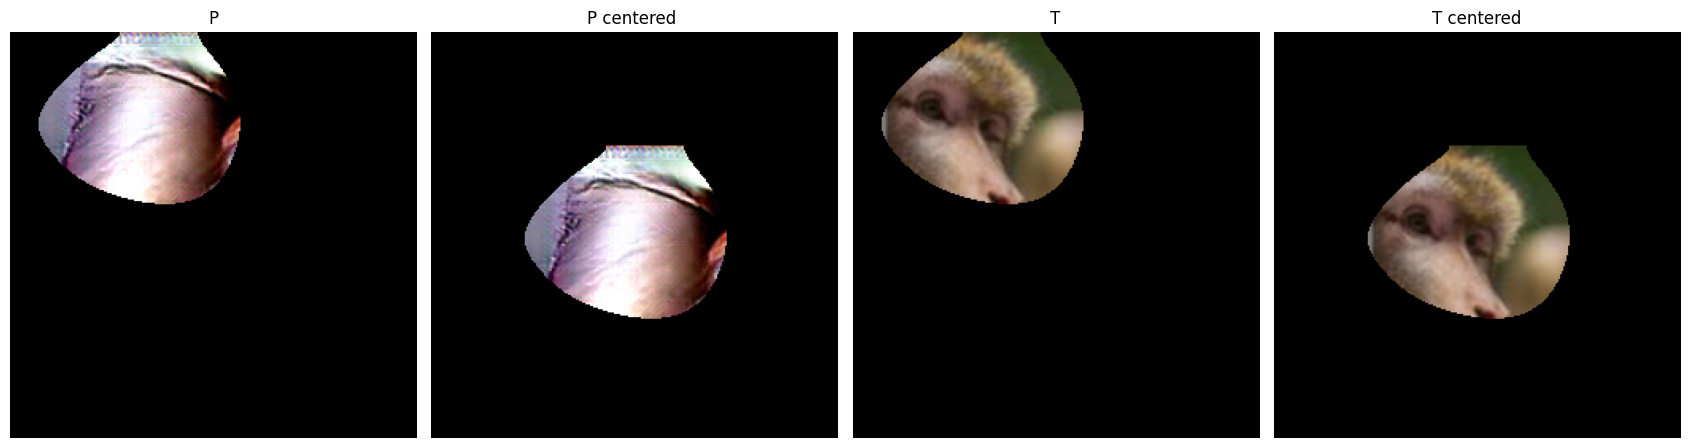

In [26]:
# let see if it makes sense by printin the masked image amd masked centered image :))
fig, ax = plt.subplots(1, 4, figsize=(17, 5))

ppi = 3
ax[0].imshow(ToPILImage()(real_pos_proto_img_tensor_masked_seleted[ppi]))
ax[0].set_title('P')
ax[0].axis('off')
ax[1].imshow(ToPILImage()(real_pos_proto_img_tensor_masked_centered_seleted[ppi]))
ax[1].set_title('P centered ')
ax[1].axis('off')
ax[2].imshow(ToPILImage()(target_img_repeated_masked[ppi]))
ax[2].set_title('T')
ax[2].axis('off')
ax[3].imshow(ToPILImage()(target_img_repeated_masked_centered[ppi]))
ax[3].set_title('T centered')
ax[3].axis('off')
plt.tight_layout()
plt.show()

In [18]:
# for all the units in the df let get correlation between the response of the units and the distance and save them in a pd
unit_resp_dist_pd['l2_dist_z'] = stats.zscore(unit_resp_dist_pd['l2_dist'])
unit_resp_dist_pd['mse_dist_z'] = stats.zscore(unit_resp_dist_pd['mse_dist'])
unit_resp_dist_pd['lpips_dist_z'] = stats.zscore(unit_resp_dist_pd['lpips_dist'])
unit_resp_dist_pd['CNN_cosine_dist_z'] = stats.zscore(unit_resp_dist_pd['CNN_cosine_dist'])

# let get the correlation between the response of the units and the distance
unit_resp_dist_corr_pd = pd.DataFrame(columns=['unit_id', 'chan_id', 'l2_dist_corr', 'mse_dist_corr', 'lpips_dist_corr', 'CNN_cosine_dist_corr'])
for pi in range(len(proto_chan_id)):
    ui = proto_unit_id[pi]
    chi = proto_chan_id[pi]
    row_filter = (unit_resp_dist_pd['unit_id'] == ui) & (unit_resp_dist_pd['chan_id'] == chi)
    sub_pd = unit_resp_dist_pd[row_filter]
    #let remove rows with nan values
    sub_pd = sub_pd.dropna()
    l2_dist_corr = np.corrcoef(sub_pd['unit_resp'], sub_pd['l2_dist'])[0, 1]
    mse_dist_corr = np.corrcoef(sub_pd['unit_resp'], sub_pd['mse_dist'])[0, 1]
    lpips_dist_corr = np.corrcoef(sub_pd['unit_resp'], sub_pd['lpips_dist'])[0, 1]
    CNN_cosine_dist_corr = np.corrcoef(sub_pd['unit_resp'], sub_pd['CNN_cosine_dist'])[0, 1]
    unit_resp_dist_corr_pd.loc[len(unit_resp_dist_corr_pd)] = [ui, chi, l2_dist_corr, mse_dist_corr, lpips_dist_corr, CNN_cosine_dist_corr]
    

In [19]:
# ket print all the raw data
for row in unit_resp_dist_corr_pd.iterrows():
    print(f'units {row[1]["unit_id"]} and {row[1]["chan_id"]}: l2_dist_corr: {row[1]["l2_dist_corr"]}, mse_dist_corr: {row[1]["mse_dist_corr"]}, lpips_dist_corr: {row[1]["lpips_dist_corr"]}, CNN_cosine_dist_corr: {row[1]["CNN_cosine_dist_corr"]}')

units 2.0 and 92.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 2.0 and 90.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 2.0 and 49.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 2.0 and 82.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 2.0 and 35.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 3.0 and 4.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 2.0 and 28.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 2.0 and 77.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 2.0 and 82.0: l2_dist_corr: nan, mse_dist_corr: nan, lpips_dist_corr: nan, CNN_cosine_dist_corr: nan
units 1.0 and 50.0: l2_dist_corr: nan,

Text(0.5, 1.0, 'proto masked')

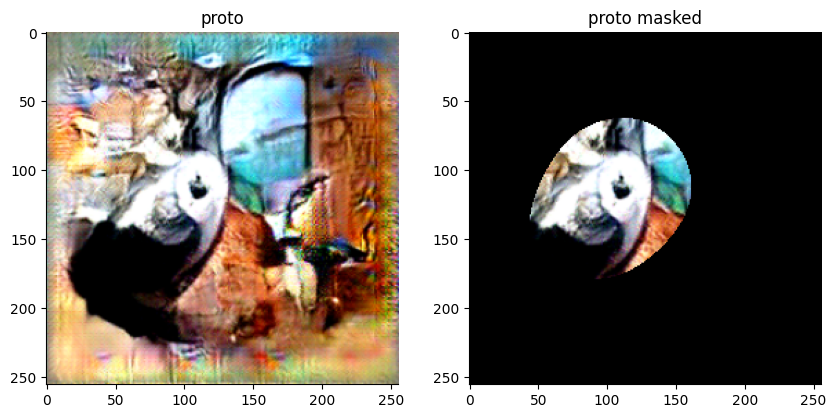

In [23]:
# let print the proto and proto_mask for selected units 
s_unit = 2
s_chan = 76
proto_idx = np.where((np.array(proto_chan_id) == s_chan) & (np.array(proto_unit_id) == s_unit))[0][0]
ax, fig = plt.subplots(1, 2, figsize=(10, 5))
fig[0].imshow(ToPILImage()(real_pos_proto_img_tensor[proto_idx]))
fig[0].set_title('proto')
fig[1].imshow(ToPILImage()(real_pos_proto_img_tensor_masked[proto_idx]))
fig[1].set_title('proto masked')


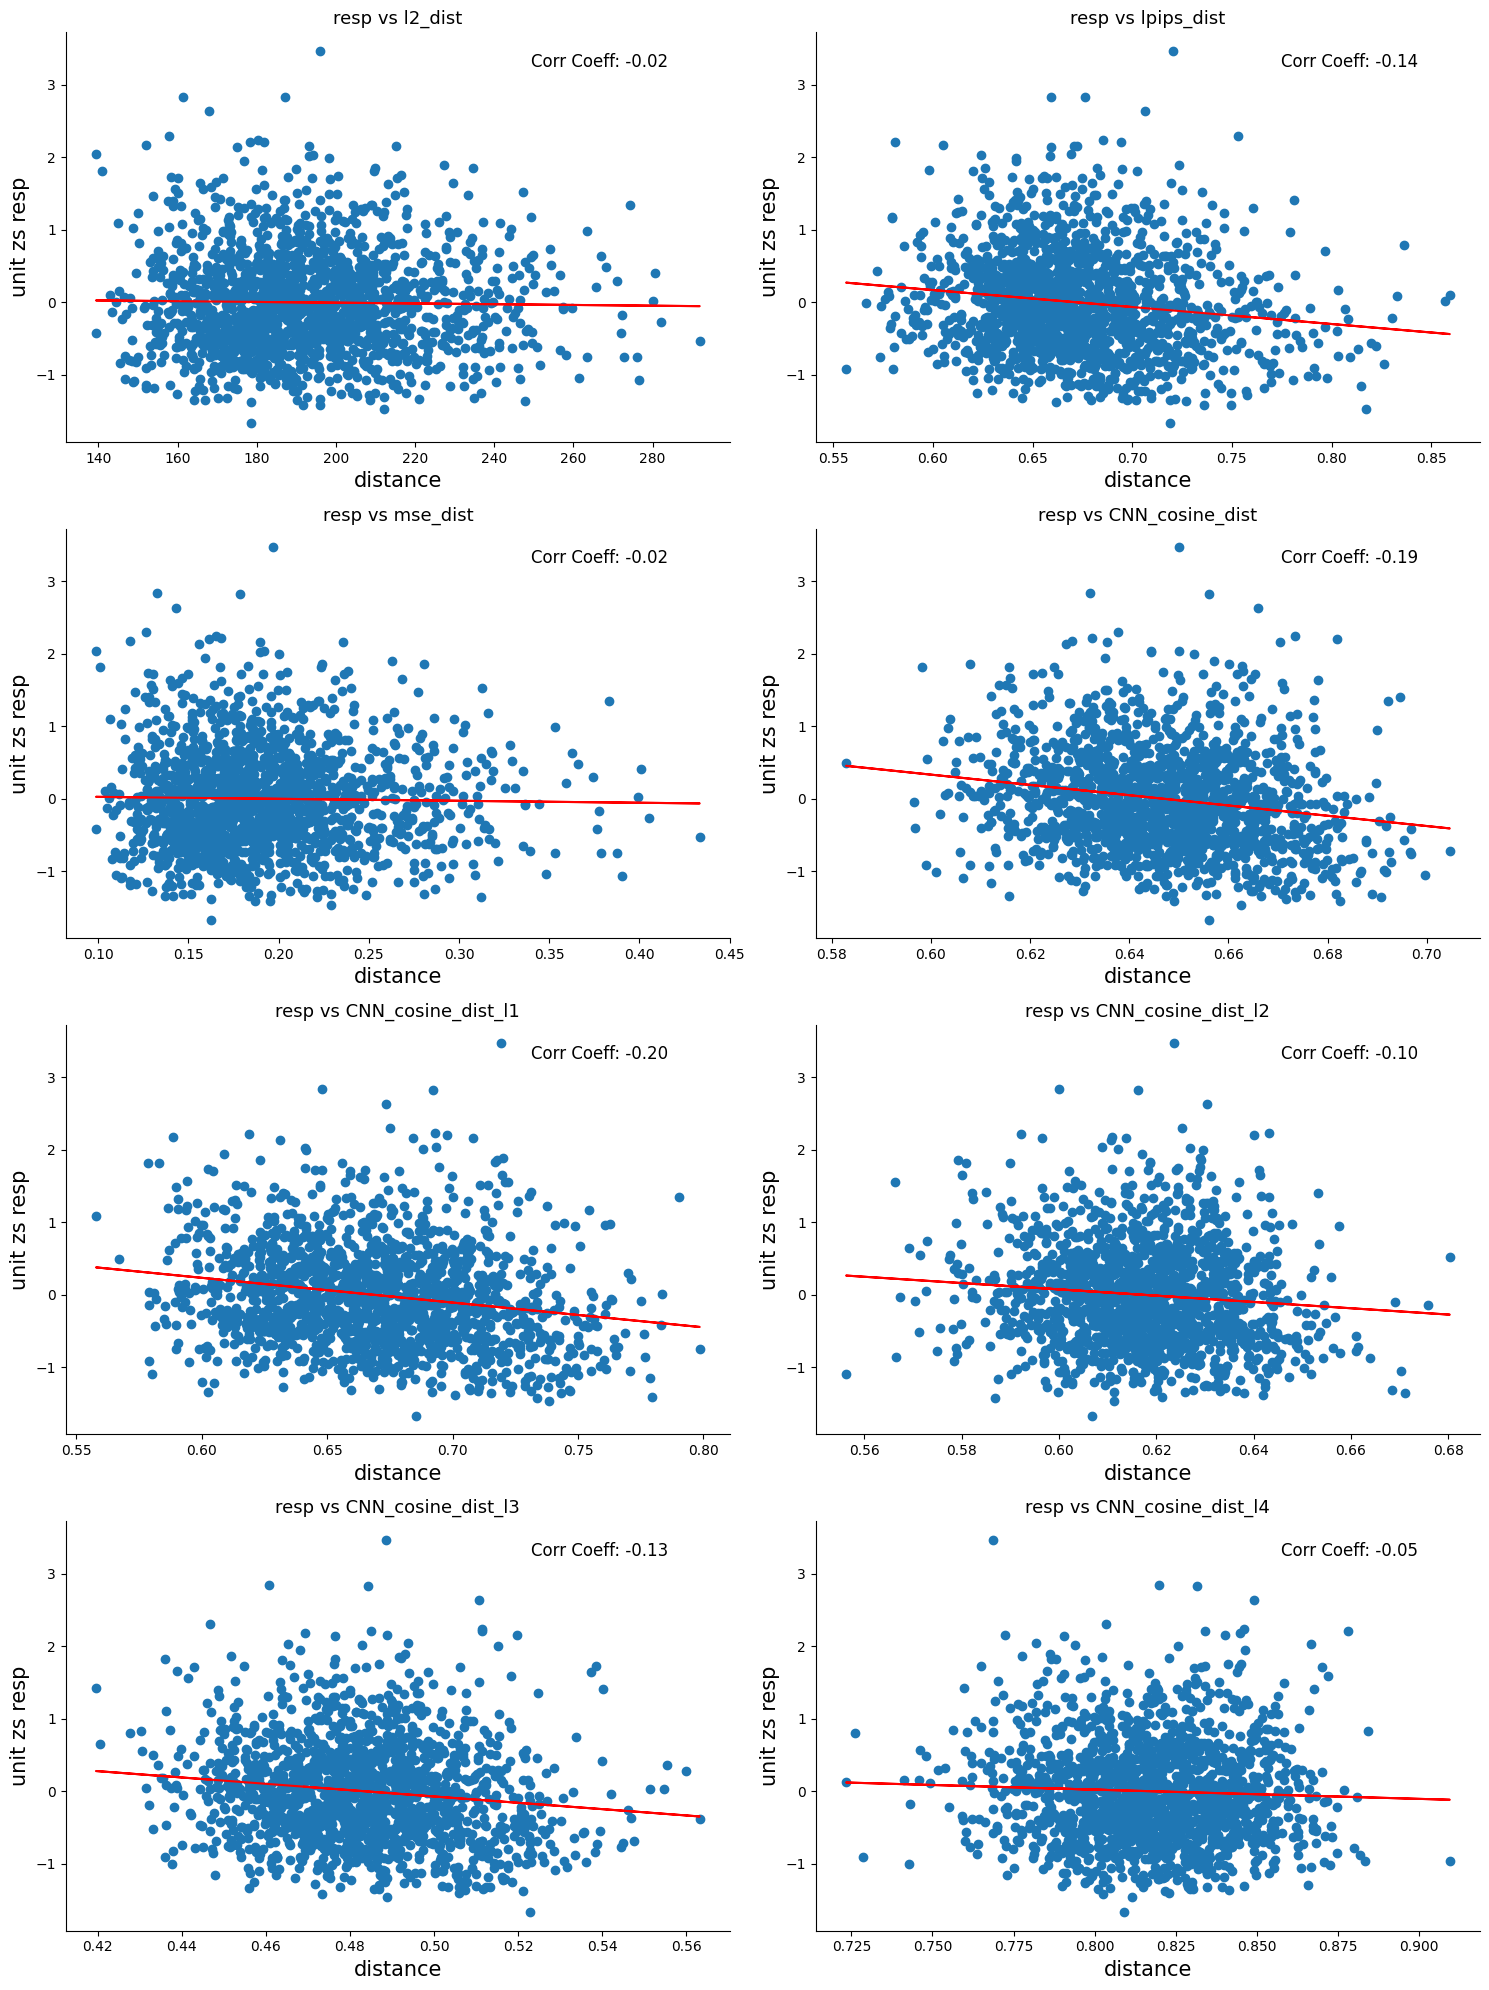

In [28]:
def clean_data(x, y):
    return x, y

# let desine a filter 
#row_filter = (unit_resp_dist_pd['unit_id'] == s_unit) &\
#                (unit_resp_dist_pd['chan_id'] == s_chan)
row_filter = unit_resp_dist_pd['chan_id'] > 0

def plot_madoul(x_clean, y_clean, ax):
    ax.scatter(x_clean, y_clean)
    # Line of best fit
    m1, b1 = np.polyfit(x_clean, y_clean, 1)
    ax.plot(x_clean, m1*x_clean + b1, color='red')  # Add line of best fit
    # Calculate the correlation coefficient
    corr_coeff1 = np.corrcoef(x_clean, y_clean)[0, 1]
    ax.text(.7, 0.95, f'Corr Coeff: {corr_coeff1:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# First subplot
fig, ax = plt.subplots(4, 2, figsize=(15, 20))
x = unit_resp_dist_pd['l2_dist'][row_filter].values # Ensure it's a numpy array
y = unit_resp_dist_pd['unit_resp'][row_filter].values

x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[0,0])
ax[0,0].set_title(f'resp vs l2_dist', fontsize=13)
ax[0,0].set_ylabel('unit zs resp', fontsize=15)
ax[0,0].set_xlabel('distance', fontsize=15)

x = unit_resp_dist_pd['mse_dist'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[1,0])
ax[1,0].set_title(f'resp vs mse_dist', fontsize=13)
ax[1,0].set_ylabel('unit zs resp', fontsize=15)
ax[1,0].set_xlabel('distance', fontsize=15)

x = unit_resp_dist_pd['lpips_dist'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[0,1])
ax[0,1].set_title(f'resp vs lpips_dist', fontsize=13)
ax[0,1].set_ylabel('unit zs resp', fontsize=15)
ax[0,1].set_xlabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[1,1])
ax[1,1].set_title(f'resp vs CNN_cosine_dist', fontsize=13)
ax[1,1].set_ylabel('unit zs resp', fontsize=15)
ax[1,1].set_xlabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_l1'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[2,0])
ax[2,0].set_title(f'resp vs CNN_cosine_dist_l1', fontsize=13)
ax[2,0].set_ylabel('unit zs resp', fontsize=15)
ax[2,0].set_xlabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_l2'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[2,1])
ax[2,1].set_title(f'resp vs CNN_cosine_dist_l2', fontsize=13)
ax[2,1].set_ylabel('unit zs resp', fontsize=15)
ax[2,1].set_xlabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_l3'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[3,0])
ax[3,0].set_title(f'resp vs CNN_cosine_dist_l3', fontsize=13)
ax[3,0].set_ylabel('unit zs resp', fontsize=15)
ax[3,0].set_xlabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_l4'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[3,1])
ax[3,1].set_title(f'resp vs CNN_cosine_dist_l4', fontsize=13)
ax[3,1].set_ylabel('unit zs resp', fontsize=15)
ax[3,1].set_xlabel('distance', fontsize=15)

plt.tight_layout()
plt.show()


Text(0, 0.5, 'distance')

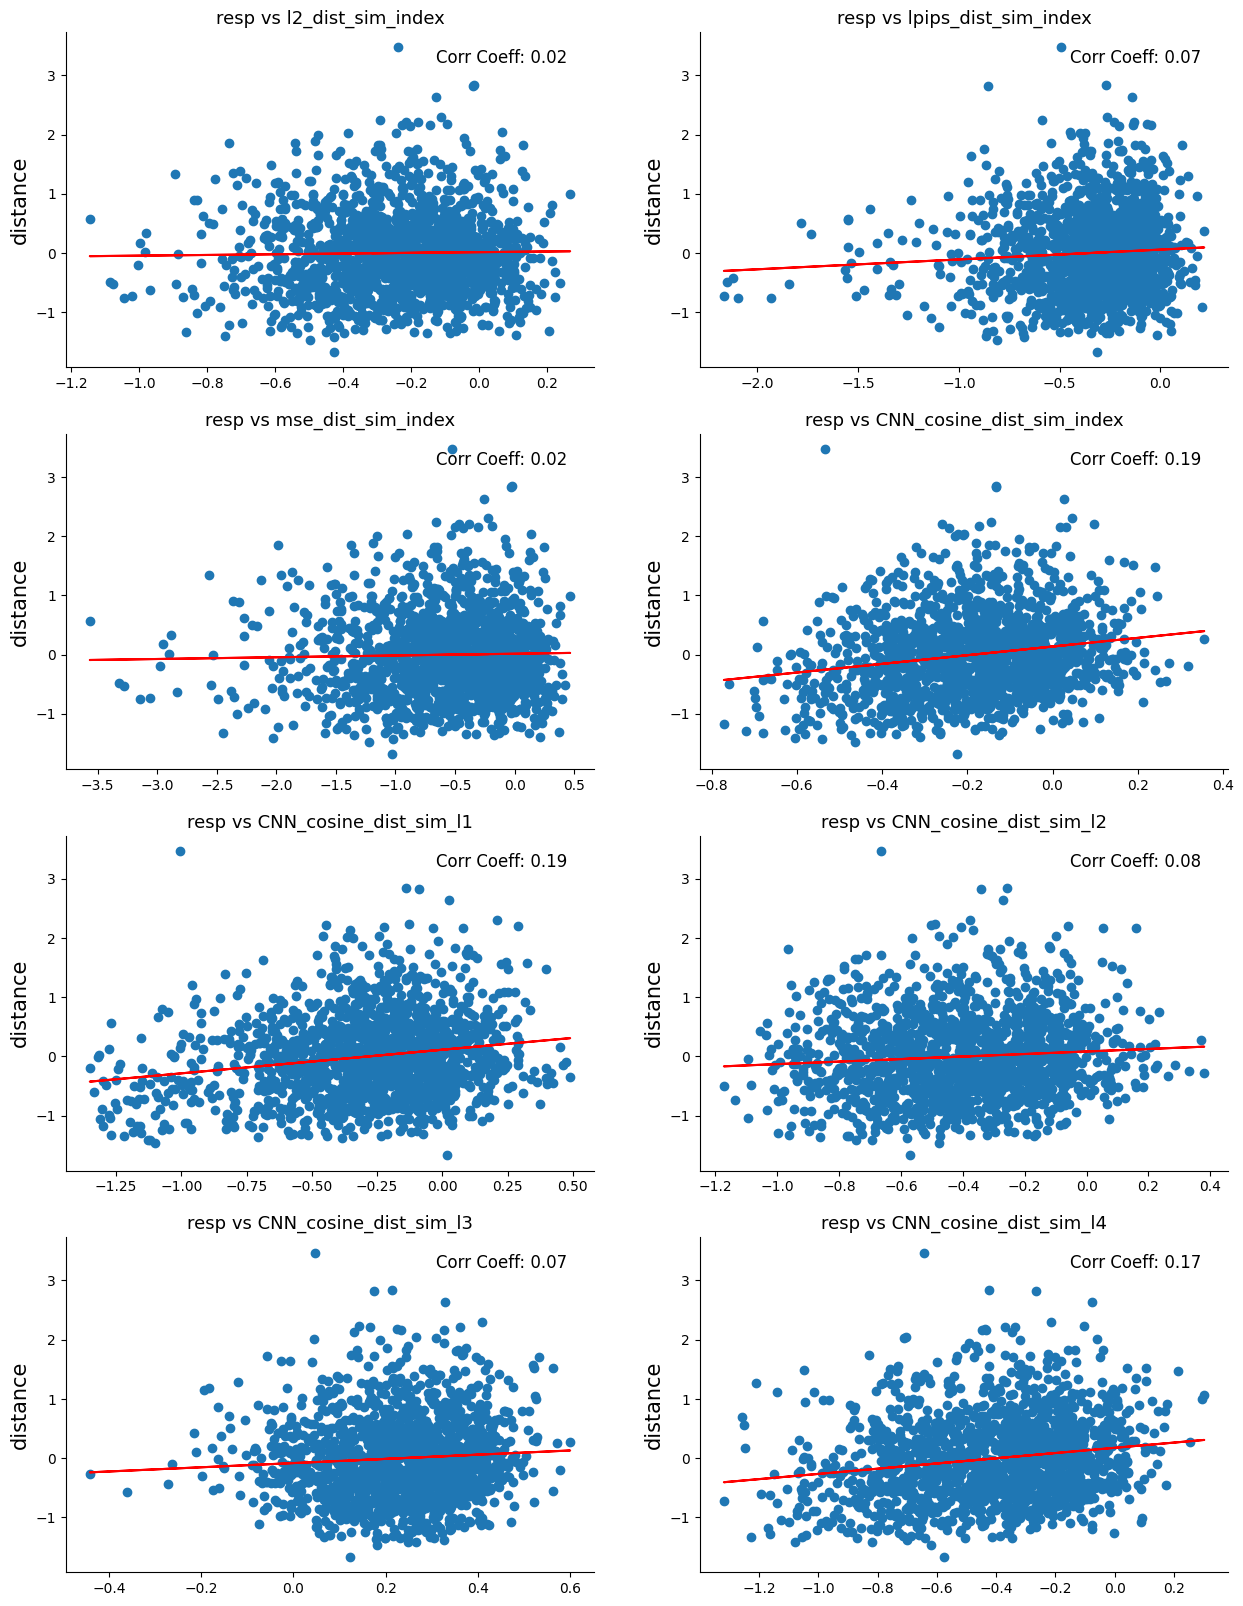

In [ ]:
#
def clean_data(x, y):
    return x, y

# let desine a filter 
#row_filter = (unit_resp_dist_pd['unit_id'] == s_unit) &\
#                (unit_resp_dist_pd['chan_id'] == s_chan)
row_filter = unit_resp_dist_pd['chan_id'] > 0

def plot_madoul(x_clean, y_clean, ax):
    ax.scatter(x_clean, y_clean)
    # Line of best fit
    m1, b1 = np.polyfit(x_clean, y_clean, 1)
    ax.plot(x_clean, m1*x_clean + b1, color='red')  # Add line of best fit
    # Calculate the correlation coefficient
    corr_coeff1 = np.corrcoef(x_clean, y_clean)[0, 1]
    ax.text(.7, 0.95, f'Corr Coeff: {corr_coeff1:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# First subplot
fig, ax = plt.subplots(4, 2, figsize=(15, 20))
y = unit_resp_dist_pd['unit_resp'][row_filter].values
x = unit_resp_dist_pd['l2_dist_sim_index'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[0,0])
ax[0,0].set_title(f'resp vs l2_dist_sim_index', fontsize=13)
ax[0,0].set_ylabel('unit zs resp', fontsize=15)
ax[0,0].set_ylabel('distance', fontsize=15)

x = unit_resp_dist_pd['mse_dist_sim_index'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[1,0])
ax[1,0].set_title(f'resp vs mse_dist_sim_index', fontsize=13)
ax[1,0].set_ylabel('unit zs resp', fontsize=15)
ax[1,0].set_ylabel('distance', fontsize=15)

x = unit_resp_dist_pd['lpips_dist_sim_index'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[0,1])
ax[0,1].set_title(f'resp vs lpips_dist_sim_index', fontsize=13)
ax[0,1].set_ylabel('unit zs resp', fontsize=15)
ax[0,1].set_ylabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_sim_index'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[1,1])
ax[1,1].set_title(f'resp vs CNN_cosine_dist_sim_index', fontsize=13)
ax[1,1].set_ylabel('unit zs resp', fontsize=15)
ax[1,1].set_ylabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_sim_l1'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[2,0])
ax[2,0].set_title(f'resp vs CNN_cosine_dist_sim_l1', fontsize=13)
ax[2,0].set_ylabel('unit zs resp', fontsize=15)
ax[2,0].set_ylabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_sim_l2'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[2,1])
ax[2,1].set_title(f'resp vs CNN_cosine_dist_sim_l2', fontsize=13)
ax[2,1].set_ylabel('unit zs resp', fontsize=15)
ax[2,1].set_ylabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_sim_l3'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[3,0])
ax[3,0].set_title(f'resp vs CNN_cosine_dist_sim_l3', fontsize=13)
ax[3,0].set_ylabel('unit zs resp', fontsize=15)
ax[3,0].set_ylabel('distance', fontsize=15)

x = unit_resp_dist_pd['CNN_cosine_dist_sim_l4'][row_filter].values # Ensure it's a numpy array
x_clean, y_clean = clean_data(x, y)  # Clean data to remove NaNs
plot_madoul(x_clean, y_clean, ax[3,1])
ax[3,1].set_title(f'resp vs CNN_cosine_dist_sim_l4', fontsize=13)
ax[3,1].set_ylabel('unit zs resp', fontsize=15)
ax[3,1].set_ylabel('distance', fontsize=15)






Text(0.5, 1.0, 'Center: [-47.  -6.] Angle: [-0.3671875 -0.046875 ]')

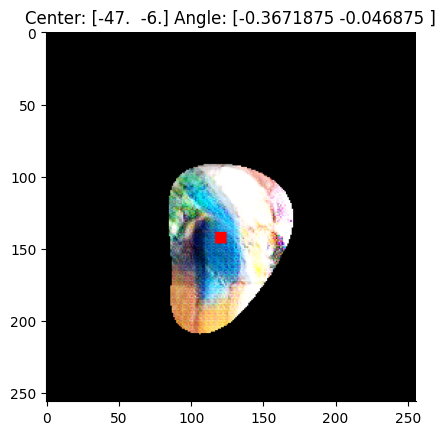

In [ ]:
# let's find the center of the mask 
def find_mask_center(mask, pixels_per_deg=128):
    mask = mask.numpy()
    mask_center = np.array(np.where(mask == 1))
    # get center by median of the x and y not the mean
    mask_center = np.median(mask_center, axis=1)
    # let find this center in cordinate cnetred at the center of the image
    mask_center_img_cordinte = np.array([mask_center[1] - mask.shape[1] / 2, mask.shape[0] / 2 - mask_center[0]])
    # convert to visual angle
    mask_center_angle = mask_center_img_cordinte / pixels_per_deg
    return mask_center, mask_center_img_cordinte, mask_center_angle
mask_center = [find_mask_center(mask) for mask in real_pos_bin_mask_list]

# add a red dot to the proto image at the mask center
def add_red_dot_to_torch_img(img, mask_center, dot_size=4):
    img = img.clone()
    img = img.permute(1, 2, 0)
    mask_center = mask_center.astype(int)
    # let add the red dot
    img[mask_center[0]-dot_size:mask_center[0]+dot_size, mask_center[1]-dot_size:mask_center[1]+dot_size, 0] = 1
    img[mask_center[0]-dot_size:mask_center[0]+dot_size, mask_center[1]-dot_size:mask_center[1]+dot_size, 1] = 0
    img[mask_center[0]-dot_size:mask_center[0]+dot_size, mask_center[1]-dot_size:mask_center[1]+dot_size, 2] = 0
    return img.permute(2, 0, 1)
# let add the red dot to the proto image
proto_img_with_red_dot = [add_red_dot_to_torch_img(proto_and_mask_info['proto_img_torch'].iloc[i], mask_center[i][0]) for i in range(len(proto_and_mask_info))]
# do the same but here for the real_pos_proto_img_tensor_masked
real_pos_proto_img_tensor_masked_with_red_dot = [add_red_dot_to_torch_img(real_pos_proto_img_tensor_masked[i], mask_center[i][0]) for i in range(len(proto_and_mask_info))]


# let shoe the proto image with the red dot
plt.figure()
plt.imshow(ToPILImage()(real_pos_proto_img_tensor_masked_with_red_dot[10]))
# add center and angle to the title
plt.title(f"Center: {mask_center[0][1]} Angle: {mask_center[0][2]}")

In [2]:
import cv2
import os

def save_video_frames(video_path, output_folder):
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_count = 0

    while True:
        # Read a new frame
        ret, frame = cap.read()
        if not ret:
            break  # Break the loop if there are no frames left

        # Save the frame as an image file
        frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    cap.release()  # Release the video capture object
    print(f"Frames saved: {frame_count}")

# Example usage
video_path = r'C:\Users\Alireza\Downloads\2024-04-28.mp4'
output_folder = r'C:\Users\Alireza\Downloads\video_frames'
save_video_frames(video_path, output_folder)

Frames saved: 564
